# Uses LSTM - CNN on the data set

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.losses import MeanSquaredError

2021-12-10 21:22:46.664772: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data = pd.read_csv("merged.csv")
data['local_15min'] = pd.to_datetime(data['local_15min'])
data.drop(['leg1v', 'leg2v', 'summary', 'grid'], axis = 1, inplace = True)
train_dates = data['local_15min']

df_for = data[['solar', 'temperature', 'cloud_cover']].astype(float)

# one month as testing set
df_for_training = df_for[:-720]
df_for_testing = df_for[8240:]

# one week as testing set
#df_for_training = df_for[:-168]
#df_for_testing = df_for[8792:]

In [3]:
df_for

,solar,temperature,cloud_cover
0,-0.002,25.25,0.68
1,-0.006,25.00,0.68
2,-0.005,24.97,0.91
3,-0.005,24.93,1.00
4,-0.005,24.84,0.94
...,...,...,...
8955,-0.025,40.49,1.00
8956,-0.012,40.33,1.00
8957,-0.012,40.49,1.00
8958,-0.011,40.80,1.00


In [4]:
# scaler transformation
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_testing_scaled = scaler.transform(df_for_testing)

In [5]:
df_for_testing_scaled.shape

(720, 3)

In [6]:
trainX = []
trainY = []

n_future = 1  
n_past = 48  # Number of past hours we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print(trainX.shape[1])
print(trainX.shape[2])

trainX shape == (8192, 48, 3).
trainY shape == (8192, 1).
48
3


In [7]:
testX = []
testY = []

#Reformat test data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))
print(trainX.shape[1])
print(trainX.shape[2])

testX shape == (672, 48, 3).
testY shape == (672, 1).
48
3


In [8]:
# define the  model

model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2021-12-10 21:22:47.870659: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-10 21:22:47.871405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-10 21:22:47.965684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:19:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-10 21:22:47.966519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-10 21:22:47.967495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:67:0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 64)            17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
461/461 [==============================] - 44s 95ms/step - loss: 0.1039 - val_loss: 0.1048
Epoch 2/40
461/461 [==============================] - 44s 96ms/step - loss: 0.1069 - val_loss: 0.0855
Epoch 3/40
461/461 [==============================] - 44s 95ms/step - loss: 0.1074 - val_loss: 0.0974
Epoch 4/40
461/461 [==============================] - 44s 95ms/step - loss: 0.1048 - val_loss: 0.0942
Epoch 5/40
461/461 [==============================] - 44s 95ms/step - loss: 0.1053 - val_loss: 0.0904
Epoch 6/40
461/461 [==============================] - 44s 95ms/step - loss: 0.1026 - val_loss: 0.0938
Epoch 7/40
461/461 [==============================] - 44s 96ms/step - loss: 0.1021 - val_loss: 0.0990
Epoch 8/40
461/461 [==============================] - 44s 96ms/step - loss: 0.1017 - val_loss: 0.0907
Epoch 9/40
461/461 [==============================] - 44s 96ms/step - loss: 0.1048 - val_loss: 0.0886
Epoch 10/40
461/461 [==============================] - 44s 96ms/step - loss: 0.100

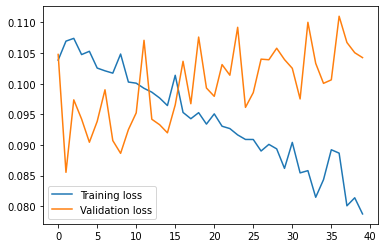

In [19]:
history = model.fit(trainX, trainY, epochs=40, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [10]:
trainX[200:].shape

(7992, 48, 3)

In [11]:

#Make prediction
prediction = model.predict(testX) 

prediction.shape

(672, 1)

In [12]:

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
pre_inverse = scaler.inverse_transform(prediction_copies)[:,0]

test_copies = np.repeat(testY, df_for_training.shape[1], axis=-1)
test_inverse = scaler.inverse_transform(test_copies)[:,0]

In [13]:
test_inverse.shape

(672,)

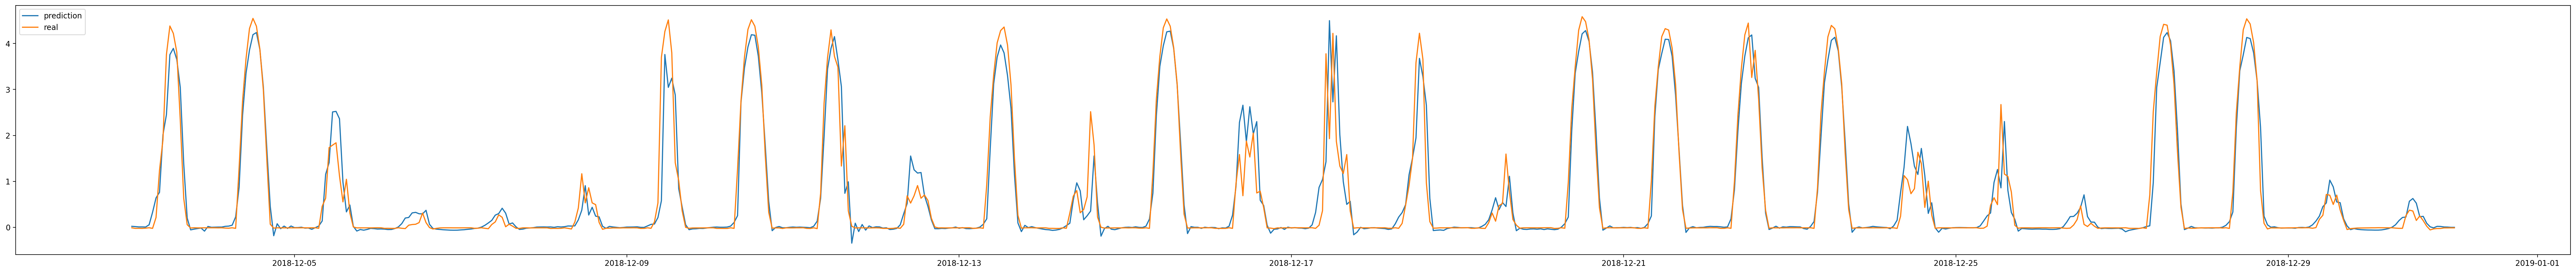

In [14]:



from matplotlib.pyplot import figure
figure(figsize=(60, 6), dpi=200)
# for one month
timestamp = train_dates[8288:]
# for one week
#timestamp = train_dates[8816:]
plt.plot(timestamp, pre_inverse)
plt.plot(timestamp, test_inverse)

plt.legend(['prediction', 'real'], loc='upper left')
plt.show()

In [15]:
mse = MeanSquaredError()
mse(pre_inverse, test_inverse).numpy()

0.15846514701843262

In [16]:
pre_inverse.shape

(672,)

In [17]:
test_inverse.shape

(672,)

In [18]:
336
336+48

384